In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import math
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from MODM_Tool_Modules import gathering_data_function as gt
from MODM_Tool_Modules import sensitivity_analysis_2_0 as sens

In [2]:
decision_matrix, data_filename, weights, normalized_weights, beneficial_criteria, non_beneficial_criteria = gt.gathering_data(
    'C:/Users/Virgi/OneDrive/Bureau/MODM_tool_project/Tool/Data/data_input/mock_data.csv')

              Price ($)  Storage (GB)  Camera (MP)  Looks (1-5)
Alternative                                                    
Phone 1             250            16           12            5
Phone 2             200            16            8            3
Phone 3             300            32           16            4
Phone 4             275            32            8            4
Phone 5             225            16           16            2


## **Min-Max Normalization**
### *Beneficial Criteria*
For each beneficial criterion:


$
x^{normalized}_{i, j}=\frac{x_{i, j}-min(x_j)}{max(x_j)-min(x_j)}
$
### *Non-Beneficial Criteria*
For each non-beneficial criterion:


$
x^{normalized}_{i, j}=\frac{max(x_j)-x_{i, j}}{max(x_j)-min(x_j)}
$

In [3]:
def min_max_normalization(decision_matrix, beneficial_criteria):
    """
    Normalize the decision matrix using min-max normalization.
    
    Parameters:
    - decision_matrix: DataFrame containing the raw scores for each alternative and criterion.
    
    Returns:
    - normalized_matrix: DataFrame containing the normalized scores.
    """
    normalized_matrix = (decision_matrix - decision_matrix.min()) / (decision_matrix.max() - decision_matrix.min())
    for criterion in decision_matrix.columns:
        if criterion not in beneficial_criteria:
            normalized_matrix[criterion] = 1 - normalized_matrix[criterion]
    return normalized_matrix

normalized_matrix = min_max_normalization(decision_matrix, beneficial_criteria)
print(normalized_matrix)

              Price ($)  Storage (GB)  Camera (MP)  Looks (1-5)
Alternative                                                    
Phone 1            0.50           0.0          0.5     1.000000
Phone 2            1.00           0.0          0.0     0.333333
Phone 3            0.00           1.0          1.0     0.666667
Phone 4            0.25           1.0          0.0     0.666667
Phone 5            0.75           0.0          1.0     0.000000


## **Preference Functions**
### *Usual Preference Function:*  
$
P(d) = 
\begin{cases} 
0 & \text{if } d \leq 0 \\
1 & \text{if } d > 0 
\end{cases}
$
### *Linear Preference Function:*
$
P(d) = 
\begin{cases} 
0 & \text{if } d \leq q \\
\frac{d - q}{p - q} & \text{if } q < d \leq p \\
1 & \text{if } d > p 
\end{cases}
$
### *Gaussian Preference Function:*
$
P(d) = 1 - e^{-\frac{d^2}{2s^2}}
$


In [4]:
def usual_preference_function(d):
    """
    Usual Preference Function.
    
    Parameters:
    - d (float): Difference between evaluations of two alternatives for a criterion.
    
    Returns:
    - float: Preference value.
    """
    if d <= 0:
        return 0
    else:
        return 1


def linear_preference_function(d, q, p):
    """
    Linear Preference Function.
    
    Parameters:
    - d (float): Difference between evaluations of two alternatives for a criterion.
    - q (float): Indifference threshold.
    - p (float): Strict preference threshold.
    
    Returns:
    - float: Preference value.
    """
    if d <= q:
        return 0
    elif q < d <= p:
        return (d - q) / (p - q)
    else:
        return 1


def gaussian_preference_function(d, s):
    """
    Gaussian Preference Function.
    
    Parameters:
    - d (float): Difference between evaluations of two alternatives for a criterion.
    - s (float): Standard deviation of the Gaussian function.
    
    Returns:
    - float: Preference value.
    """
    if d <= 0:
        return 0
    return 1 - math.exp(-d**2 / (2 * s**2))

In [5]:
def plot_gaussian_preference_function(s):
    X = np.arange(0, 1, 0.01)
    Y = 1 - np.exp(-X**2 / (2 * s**2))
    plt.plot(X, Y)
ipywidgets.interact(plot_gaussian_preference_function, s=(0.01, 2, 0.1))

interactive(children=(FloatSlider(value=0.91, description='s', max=2.0, min=0.01), Output()), _dom_classes=('w…

<function __main__.plot_gaussian_preference_function(s)>

### **d values**
The parameter $d$ represents the difference in the evaluation of two alternatives with respect to a specific criterion.

$d(a_i, a_j) = f(a_i) - f(a_j)$

Where:

$a_i$ and $a_j$ are two alternatives being compared.


$f(a_i)$ and $f(a_j)$ are the evaluations of the alternatives $a_i$ and $a_j$ respectively, for a specific criterion.



In [6]:
def compute_d_values(decision_matrix):
    """
    Computes the pairwise differences for each criterion and each pair of alternatives.
    
    Parameters:
    - decision_matrix: A pandas DataFrame containing the normalized decision matrix.
    
    Returns:
    - A pandas DataFrame containing the pairwise differences.
    """
    alternatives = decision_matrix.index
    criteria = decision_matrix.columns
    
    # Create an empty dataframe to store the results
    d_values_df = pd.DataFrame()
    
    # Iterate over each criterion
    for criterion in criteria:
        # Compute pairwise differences for the current criterion
        for alt_i in alternatives:
            for alt_j in alternatives:
                if alt_i != alt_j:
                    d_key = f"d({alt_i}, {alt_j})"
                    d = decision_matrix.loc[alt_i, criterion] - decision_matrix.loc[alt_j, criterion]
                    d_values_df.loc[d_key, criterion] = d
                    
    return d_values_df


d_values_df = compute_d_values(normalized_matrix)
print(d_values_df)

                      Price ($)  Storage (GB)  Camera (MP)  Looks (1-5)
d(Phone 1, Phone 2)       -0.50           0.0          0.5     0.666667
d(Phone 1, Phone 3)        0.50          -1.0         -0.5     0.333333
d(Phone 1, Phone 4)        0.25          -1.0          0.5     0.333333
d(Phone 1, Phone 5)       -0.25           0.0         -0.5     1.000000
d(Phone 2, Phone 1)        0.50           0.0         -0.5    -0.666667
d(Phone 2, Phone 3)        1.00          -1.0         -1.0    -0.333333
d(Phone 2, Phone 4)        0.75          -1.0          0.0    -0.333333
d(Phone 2, Phone 5)        0.25           0.0         -1.0     0.333333
d(Phone 3, Phone 1)       -0.50           1.0          0.5    -0.333333
d(Phone 3, Phone 2)       -1.00           1.0          1.0     0.333333
d(Phone 3, Phone 4)       -0.25           0.0          1.0     0.000000
d(Phone 3, Phone 5)       -0.75           1.0          0.0     0.666667
d(Phone 4, Phone 1)       -0.25           1.0         -0.5    -0

### **Preference values**
Given the pairwise differences $d$ and the preference functions $p(d)$, the preference value $\pi (a_i, a_j)$ for each criterion between two alternatives $a_i$ and $a_j$ is simply the value of the preference function evaluated at $d(a_i, a_j)$.

In [7]:
def compute_preference_values(d_values_df, preference_functions):
    """
    Compute the preference values for each criterion and each pair of alternatives.
    
    Parameters:
    - differences_df: DataFrame containing the pairwise differences.
    - preference_functions: Dictionary mapping criteria to their corresponding preference functions.
    
    Returns:
    - DataFrame containing the preference values.
    """
    preference_values_df = d_values_df.copy()
    preference_values_df.index = ['p(' + str(idx) + ')'for idx in preference_values_df.index]


    for criterion, pref_func in preference_functions.items():
        preference_values_df[criterion] = preference_values_df[criterion].apply(pref_func)
    
    return preference_values_df


def define_preference_functions(decision_matrix):
    preference_functions = {}
    for criterion in decision_matrix.columns:
        response = input(f"What preference function do you want to use for {criterion}?\nEnter 'u' for usual preference function.\nEnter 'l' for linear preference function.\nEnter 'g' for gaussian preference function.\n").lower()
        while response not in ['u', 'l', 'g']:
            print(
                "Invalid input. Please enter 'u', 'l' or 'g'.")
            response = input(
                f"What preference function do you want to use for {criterion}? ").lower()
        if response == 'u':
            preference_functions[criterion] = lambda d: usual_preference_function(d)   
        elif response == 'l':
            preference_functions[criterion] = lambda d: linear_preference_function(d, q=0.2, p=0.8) 
        else:
            preference_functions[criterion] = lambda d: gaussian_preference_function(d, s=0.3)
    return preference_functions


preference_functions = define_preference_functions(decision_matrix)
preference_values_df = compute_preference_values(d_values_df, preference_functions)
print(preference_values_df)

                         Price ($)  Storage (GB)  Camera (MP)  Looks (1-5)
p(d(Phone 1, Phone 2))    0.000000      0.000000     0.750648     0.915342
p(d(Phone 1, Phone 3))    0.750648      0.000000     0.000000     0.460592
p(d(Phone 1, Phone 4))    0.293352      0.000000     0.750648     0.460592
p(d(Phone 1, Phone 5))    0.000000      0.000000     0.000000     0.996134
p(d(Phone 2, Phone 1))    0.750648      0.000000     0.000000     0.000000
p(d(Phone 2, Phone 3))    0.996134      0.000000     0.000000     0.000000
p(d(Phone 2, Phone 4))    0.956063      0.000000     0.000000     0.000000
p(d(Phone 2, Phone 5))    0.293352      0.000000     0.000000     0.460592
p(d(Phone 3, Phone 1))    0.000000      0.996134     0.750648     0.000000
p(d(Phone 3, Phone 2))    0.000000      0.996134     0.996134     0.460592
p(d(Phone 3, Phone 4))    0.000000      0.000000     0.996134     0.000000
p(d(Phone 3, Phone 5))    0.000000      0.996134     0.000000     0.915342
p(d(Phone 4, Phone 1))   

## **Net Outranking Flows computation and ranking**
### **Global Preference $P(a, b)$:**
$P(a, b) = \sum_{j} w_j \times p_j(a, b)$

Where $w_j$ is the weight of criterion $j$, and $p_j(a, b)$ is the preference of alternative $a$ over alternative $b$ for criterion $j$.
### **Positive Outranking Flow $\Phi^+$:**
$\Phi^+(a) = \frac{1}{n-1} \sum_{b \neq a} P(a, b)$

Where $P(a,b)$ is the global preference of alternative $a$ over alternative $b$, and $n$ is the number of alternatives.
### **Negative Outranking Flow $\Phi^-$:**
$\Phi^-(a) = \frac{1}{n-1} \sum_{b \neq a} P(b, a)$

Where $P(b,a)$ is the global preference of alternative $b$ over alternative $a$, and $n$ is the number of alternatives.
### **Net Outranking Flow $\Phi(a)$:**
$\Phi(a) = \Phi^+(a) - \Phi^-(a)$

The alternatives are then ranked based on their net outranking flows.




In [8]:
def compute_global_preference_values(preference_values_df, normalized_weights, decision_matrix):
    """
    Compute the global preference values for pairs of alternatives.

    Parameters:
    - preference_matrix: DataFrame containing preference values for each criterion.
    - weights: Dictionary containing weights for each criterion.

    Returns:
    - DataFrame containing global preference values for pairs of alternatives.
    """
    # Multiply the preference matrix by the weights
    weighted_preference_values_df = preference_values_df.multiply(normalized_weights)
    
    # Sum across the criteria to get the global preference values
    global_preference_values_serie = weighted_preference_values_df.sum(axis=1)

    # Modify the label names
    alternatives = decision_matrix.index
    index_keys = []
    for alt_i in alternatives:
            for alt_j in alternatives:
                if alt_i != alt_j:
                    index_key = f"P({alt_i}, {alt_j})"
                    index_keys.append(index_key)
    global_preference_values_serie.index = [idx for idx in index_keys]

    return global_preference_values_serie
global_preference_values_serie = compute_global_preference_values(preference_values_df, normalized_weights, decision_matrix)
print(global_preference_values_serie)

P(Phone 1, Phone 2)    0.416497
P(Phone 1, Phone 3)    0.302810
P(Phone 1, Phone 4)    0.376148
P(Phone 1, Phone 5)    0.249034
P(Phone 2, Phone 1)    0.187662
P(Phone 2, Phone 3)    0.249034
P(Phone 2, Phone 4)    0.239016
P(Phone 2, Phone 5)    0.188486
P(Phone 3, Phone 1)    0.436695
P(Phone 3, Phone 2)    0.613215
P(Phone 3, Phone 4)    0.249034
P(Phone 3, Phone 5)    0.477869
P(Phone 4, Phone 1)    0.249034
P(Phone 4, Phone 2)    0.364182
P(Phone 4, Phone 3)    0.073338
P(Phone 4, Phone 5)    0.477869
P(Phone 5, Phone 1)    0.261000
P(Phone 5, Phone 2)    0.249034
P(Phone 5, Phone 3)    0.239016
P(Phone 5, Phone 4)    0.436695
dtype: float64


In [9]:
def series_to_matrix(global_preference_values_serie, decision_matrix):
    alternatives = decision_matrix.index
    matrix_df = pd.DataFrame(0.0, index=alternatives, columns=alternatives)

    for alt_i in alternatives:
        for alt_j in alternatives:
            if alt_i != alt_j:
                key = f"P({alt_i}, {alt_j})"
                value = global_preference_values_serie.get(key, None)
                if value is not None:
                    matrix_df.at[alt_i, alt_j] = value
                else:
                    print(f"Key not found: {key}")
    return matrix_df
matrix_df = series_to_matrix(global_preference_values_serie, decision_matrix)
print(matrix_df)

Alternative   Phone 1   Phone 2   Phone 3   Phone 4   Phone 5
Alternative                                                  
Phone 1      0.000000  0.416497  0.302810  0.376148  0.249034
Phone 2      0.187662  0.000000  0.249034  0.239016  0.188486
Phone 3      0.436695  0.613215  0.000000  0.249034  0.477869
Phone 4      0.249034  0.364182  0.073338  0.000000  0.477869
Phone 5      0.261000  0.249034  0.239016  0.436695  0.000000


In [10]:
def calculate_flows(matrix_df):
    """
    Calculate the positive, negative, and net outranking flows.

    Parameters:
    - global_preference_matrix: DataFrame containing global preference values.
    - n: The number of alternatives.

    Returns:
    - Tuple of DataFrames for positive, negative, and net flows.
    """
    n = len(matrix_df)
    # Calculate positive flows
    positive_flows = matrix_df.sum(axis=1) / (n - 1)
    
    # Calculate negative flows
    negative_flows = matrix_df.sum(axis=0) / (n - 1)
    
    # Calculate net flows
    net_flows = positive_flows - negative_flows
    
    ranked_alternatives = net_flows.sort_values(ascending=False)

    ranks = net_flows.rank(ascending=False).astype(int)

    return net_flows, ranked_alternatives, ranks
net_flows, ranked_alternatives, ranks = calculate_flows(matrix_df)
print(ranked_alternatives)
print(ranks)

Alternative
Phone 3    0.228154
Phone 1    0.052525
Phone 4   -0.034118
Phone 5   -0.051878
Phone 2   -0.194683
dtype: float64
Alternative
Phone 1    2
Phone 2    5
Phone 3    1
Phone 4    3
Phone 5    4
dtype: int32


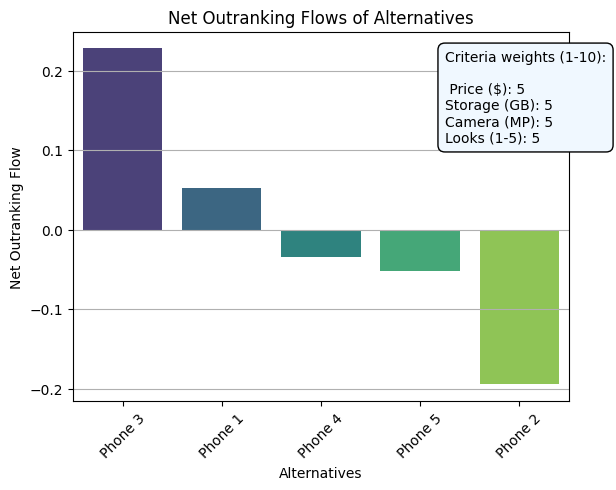

In [11]:
def plot_bar_chart_promethee(net_flows, weights):
    # Sort net_flows for better visualization
    sorted_net_flows = net_flows.sort_values(ascending=False)

    # Plot
    df = sorted_net_flows.reset_index()
    df.columns = ['Alternatives', 'Net Outranking Flow']
    colors = sns.color_palette("viridis", len(net_flows))
    sns.barplot(
        x='Alternatives',
        y='Net Outranking Flow',
        data=df,
        palette=colors,
        hue='Alternatives')
    plt.title('Net Outranking Flows of Alternatives')
    plt.ylabel('Net Outranking Flow')
    plt.xlabel('Alternatives')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    weights_text = "Criteria weights (1-10):\n\n" + "\n".join(
        [f"{criterion}: {int(weight)}" for criterion, weight in weights.items()])
    plt.text(
        0.75,
        0.95,
        weights_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(
            boxstyle='round,pad=0.5',
            facecolor='aliceblue',
            edgecolor='black'))
    """ if user_input == 'yes':
        plt.tight_layout()
        plt.savefig(
            os.path.join(
                directory,
                'bar_chart.png'),
            dpi=500,
            bbox_inches='tight') """
    plt.show()
plot_bar_chart_promethee(net_flows, weights)